# Kmeans on spherical coordinates

In [1]:
import os
import sys
sys.path.append("/home/rohit/PhD_Work/GM_my_version/Graph_matching/")
from sklearn.cluster import KMeans
import networkx as nx
import numpy as np
from graph_generation.load_graphs_and_create_metadata import dataset_metadata
from graph_matching_tools.metrics import matching
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
path_to_graph_folder = '/home/rohit/PhD_Work/GM_my_version/Graph_matching/data/simu_graph/NEW_SIMUS_JULY_11/'

In [3]:
def get_permutation_matrix_from_dictionary(matching, g_sizes):
    """
    Create the full permutation matrix from the matching result
    :param matching: the matching result for each graph (nodes number, assignment)
    :param g_sizes: the list of the size of the different graph
    :return: the full permutation matrix
    """
    f_size = int(np.sum(g_sizes))
    res = np.zeros((f_size, f_size))

    idx1 = 0
    for i_g1 in range(len(g_sizes)):
        idx2 = 0
        for i_g2 in range(len(g_sizes)):
            match = matching["{},{}".format(i_g1, i_g2)]
            for k in match:
                res[idx1 + int(k), idx2 + match[k]] = 1
            idx2 += g_sizes[i_g2]
        idx1 += g_sizes[i_g1]
        
    np.fill_diagonal(res,1)
    return res

In [4]:
def get_all_coords(list_graphs):
    all_coords = []
    for g in list_graphs:
        coords = np.array(list(nx.get_node_attributes(g,'coord').values()))
        all_coords.extend(coords)
    all_coords = np.array(all_coords)
    
    return all_coords

In [5]:
def create_perm_from_labels(labels):
    U = np.zeros((len(labels),len(set(labels))))
    
    for node,label in zip(range(U.shape[0]),labels):
        U[node,label] = 1
        
    return U @ U.T,U

In [6]:
def get_labels_from_k_means(k, coords):
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(coords)
    
    return kmeans.labels_

In [7]:
trials = np.sort(os.listdir(path_to_graph_folder))

k = 110

scores = {100:[],200:[],400:[],1000:[]}
prec_scores = {100:[],200:[],400:[],1000:[]}
rec_scores = {100:[],200:[],400:[],1000:[]}

for trial in trials:
    print('trial: ', trial)
    
    all_files = os.listdir(path_to_graph_folder+trial)
    
    for folder in all_files:
        
        if os.path.isdir(path_to_graph_folder+trial+'/'+ folder):
            
            print('Noise folder: ',folder)
            
            path_to_graphs = path_to_graph_folder + '/' + trial + '/' + folder+'/graphs/'
            path_to_groundtruth_ref = path_to_graph_folder + '/' + trial +'/' + folder + '/permutation_to_ref_graph.gpickle'
            path_to_groundtruth  = path_to_graph_folder + '/' + trial + '/' + folder + '/ground_truth.gpickle'
            
            
            noise = folder.split(',')[0].split('_')[1]
            

            graph_meta = dataset_metadata(path_to_graphs, path_to_groundtruth_ref)
            all_coords = get_all_coords(graph_meta.list_graphs)
            ground_truth =  nx.read_gpickle(path_to_groundtruth)   
            res = get_permutation_matrix_from_dictionary(ground_truth, graph_meta.sizes)            
            
            kmeans_labels = get_labels_from_k_means(k, all_coords)
            
            P,U = create_perm_from_labels(kmeans_labels)
            
            kmeans_X = {}
            kmeans_X['full_assignment_mat'] = P
            kmeans_X['U'] = U
            
            sio.savemat(path_to_graph_folder + '/' + trial + '/' + folder + '/X_kmeans_k_110.mat',kmeans_X,do_compression=True)
            
            f1, prec, rec = matching.compute_f1score(P,res)
            
            scores[int(noise)].append(f1)
            prec_scores[int(noise)].append(prec)
            rec_scores[int(noise)].append(rec)

trial:  0
Noise folder:  noise_100,outliers_varied
Noise folder:  noise_400,outliers_varied
Noise folder:  noise_200,outliers_varied
Noise folder:  noise_1000,outliers_varied
trial:  1
Noise folder:  noise_100,outliers_varied
Noise folder:  noise_400,outliers_varied
Noise folder:  noise_200,outliers_varied
Noise folder:  noise_1000,outliers_varied
trial:  2
Noise folder:  noise_100,outliers_varied
Noise folder:  noise_400,outliers_varied
Noise folder:  noise_200,outliers_varied
Noise folder:  noise_1000,outliers_varied
trial:  3
Noise folder:  noise_100,outliers_varied
Noise folder:  noise_400,outliers_varied
Noise folder:  noise_200,outliers_varied
Noise folder:  noise_1000,outliers_varied
trial:  4
Noise folder:  noise_100,outliers_varied
Noise folder:  noise_400,outliers_varied
Noise folder:  noise_200,outliers_varied
Noise folder:  noise_1000,outliers_varied
trial:  5
Noise folder:  noise_100,outliers_varied
Noise folder:  noise_400,outliers_varied
Noise folder:  noise_200,outliers

In [9]:
nx.write_gpickle(scores,'NEW_SIMU_kmeans_F1_score_k_'+ str(k) +'.gpickle')
nx.write_gpickle(prec_scores,'NEW_SIMU_kmeans_prec_score_k_'+ str(k) +'.gpickle')
nx.write_gpickle(rec_scores,'NEW_SIMU_kmeans_rec_score_k_'+ str(k) +'.gpickle')

In [11]:
k_70 = nx.read_gpickle('NEW_SIMU_kmeans_F1_score_k_70.gpickle')
k_90 = nx.read_gpickle('NEW_SIMU_kmeans_F1_score_k_90.gpickle')
k_110 = nx.read_gpickle('NEW_SIMU_kmeans_F1_score_k_110.gpickle')

In [12]:
def score_mean_std(scores):
    
    avg_scores = []
    std_scores = []

    for keys,values in scores.items():
        avg_scores.append(np.mean(values))
        std_scores.append(np.std(values))
        
    return np.array(avg_scores), np.array(std_scores)

In [14]:
k_70_mean, k_70_std  = score_mean_std(k_70)
k_90_mean, k_90_std  = score_mean_std(k_90)
k_110_mean, k_110_std = score_mean_std(k_110)

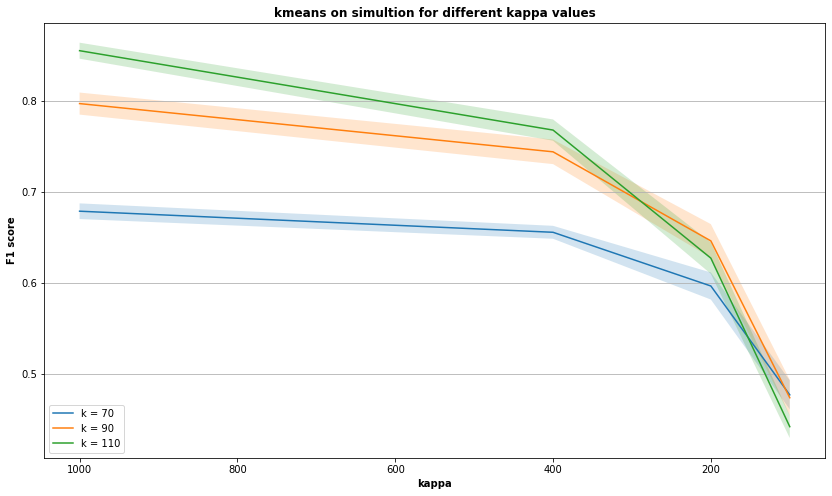

In [15]:
plt.figure(figsize=(14, 8))

plt.plot(list(k_70.keys()), k_70_mean ,label = 'k = 70')
plt.fill_between(list(k_70.keys()), k_70_mean-k_70_std, k_70_mean + k_70_std, alpha=0.2)


plt.plot(list(k_90.keys()), k_90_mean ,label = 'k = 90')
plt.fill_between(list(k_90.keys()), k_90_mean - k_90_std, k_90_mean + k_90_std, alpha=0.2)


plt.plot(list(k_110.keys()), k_110_mean ,label = 'k = 110')
plt.fill_between(list(k_110.keys()), k_110_mean - k_110_std, k_110_mean + k_110_std, alpha=0.2)


plt.xlabel('kappa',fontweight="bold")
plt.ylabel('F1 score',fontweight="bold")
plt.legend(loc = 'lower left')
plt.title('kmeans on simultion for different kappa values',fontweight="bold")
plt.gca().yaxis.grid(True)
plt.gca().invert_xaxis()
plt.show()